In this notebook XGBoost is used to predict the quantity of waste material which arrives at the incineration plant.

In [1]:
import pandas as pd
import numpy as np

from data_preparation import DataProcessor

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [2]:
waste_data = pd.read_csv("synthetic_waste_data.csv")

Forecasting the time series "quantity_tons"

In [104]:
fetcher = DataProcessor(waste_data)

prepared_data = fetcher.prepare_quantity_tons()
feature_data = fetcher.create_lagged_boosting_features(prepared_data, lags=[3,4,5,6,7,90,91,365])
feature_data.head(10)

,is_weekend,is_holiday,is_Fall,is_Spring,is_Summer,is_Winter,quantity_tons,dayofweek,quarter,month,...,dayofyear,dayofmonth,weekofyear,lag_ratio_3_4,lag_ratio_4_5,lag_ratio_5_6,lag_ratio_6_7,lag_ratio_7_90,lag_ratio_90_91,lag_ratio_91_365
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,1.0,1.0,0.0,0.0,0.0,1.0,153.851503,5,1,1,...,1,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,1.0,0.0,0.0,0.0,0.0,1.0,245.846278,6,1,1,...,2,2,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03,0.0,0.0,0.0,0.0,0.0,1.0,574.139774,0,1,1,...,3,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,0.0,0.0,0.0,0.0,0.0,1.0,446.454597,1,1,1,...,4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,0.0,0.0,0.0,0.0,0.0,1.0,141.906455,2,1,1,...,5,5,1,1.597945,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,0.0,0.0,0.0,0.0,0.0,1.0,310.036574,3,1,1,...,6,6,1,2.335361,1.597945,NaN,NaN,NaN,NaN,NaN
2022-01-07,0.0,0.0,0.0,0.0,0.0,1.0,274.158610,4,1,1,...,7,7,1,0.777606,2.335361,1.597945,NaN,NaN,NaN,NaN
2022-01-08,1.0,0.0,0.0,0.0,0.0,1.0,131.982929,5,1,1,...,8,8,1,0.317852,0.777606,2.335361,1.597945,NaN,NaN,NaN
2022-01-09,1.0,0.0,0.0,0.0,0.0,1.0,59.010134,6,1,1,...,9,9,1,2.184795,0.317852,0.777606,2.335361,NaN,NaN,NaN


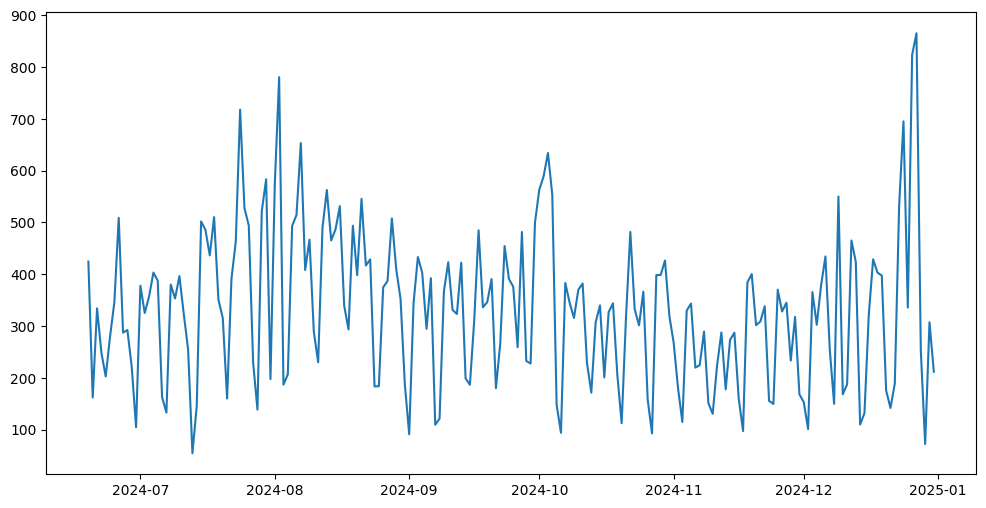

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(feature_data.index, feature_data["quantity_tons"])
plt.show()

Defining features and targets

In [22]:
X = feature_data.drop(columns=['quantity_tons'])
y = feature_data['quantity_tons']

print(f"Shape of X:{X.shape}\nShape of Y {y.shape}")

Shape of X:(1096, 24)
Shape of Y (1096,)


Using 80% of the data for training and the rest for testing

In [23]:
split_index = int(len(feature_data) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Performing gridsearch to find a well suited hyperparameter configuration

In [24]:
param_grid = {
    'n_estimators': np.arange(70,200,10),
    'learning_rate': np.arange(0.03,0.15,0.02),
    'max_depth': [3,4,5,6]
}

tscv = TimeSeriesSplit(n_splits=2)  # Adjust n_splits as needed


# random state for reproducability: 42
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', #RMSE used for scoring
    verbose=1,
    n_jobs=-1, # using all CPU cores 
    cv=tscv  # Use TimeSeriesSplit to prevent data leakage
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

Fitting 2 folds for each of 312 candidates, totalling 624 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 90}
Best RMSE: 95.86950220578285


Training the best model & visualizing the output

RMSE: 27.17


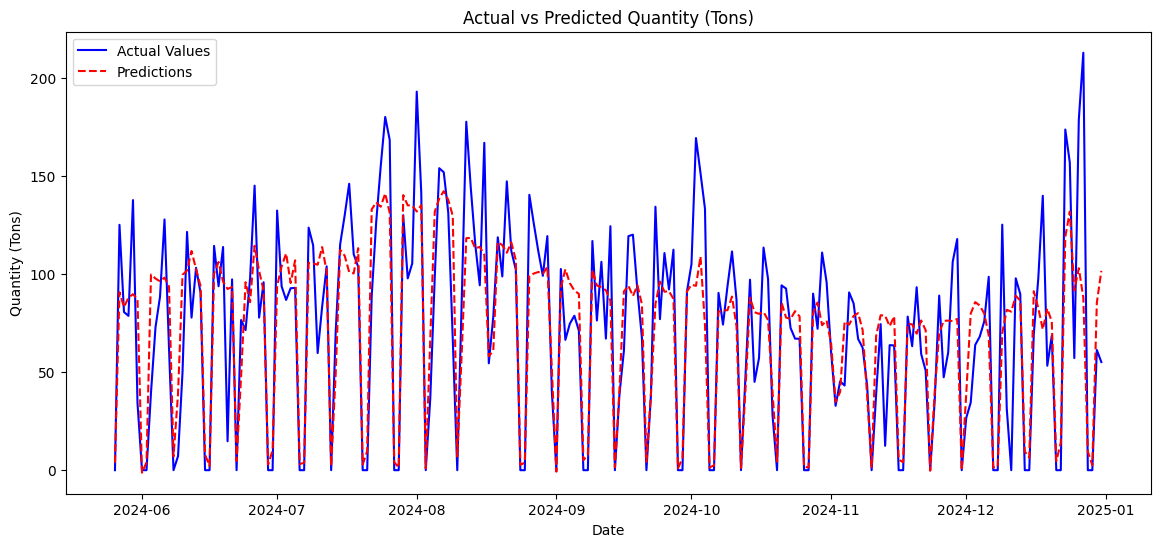

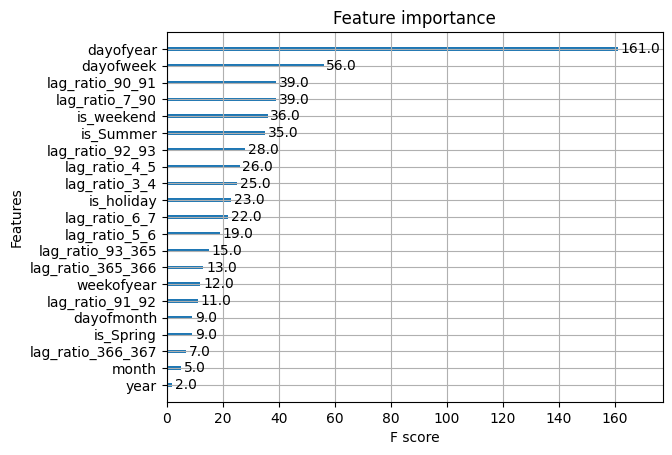

In [61]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(feature_data.index[split_index:], y_test, label='Actual Values', color='blue')
plt.plot(feature_data.index[split_index:], y_pred, label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.title('Actual vs Predicted Quantity (Tons)')
plt.legend()
plt.show()

# Plot feature importance
xgb.plot_importance(best_model)
plt.show()

Instead of forecasting the aggregated amount of waste material, XGBoost is used to predict the quantity of each company individually and the results are aggregated in the end. The idea is to learn the specific patterns of the individual companies.

In [118]:
unique_companies = fetcher.waste_data['company'].unique()

company_dfs = {}

for company in unique_companies:
    prep_data_compand = fetcher.prepare_quantity_tons_by_company(company)
    company_dfs[company] = fetcher.create_lagged_boosting_features(prep_data_compand, lags=[3,4,5,6,7,90,91,365])

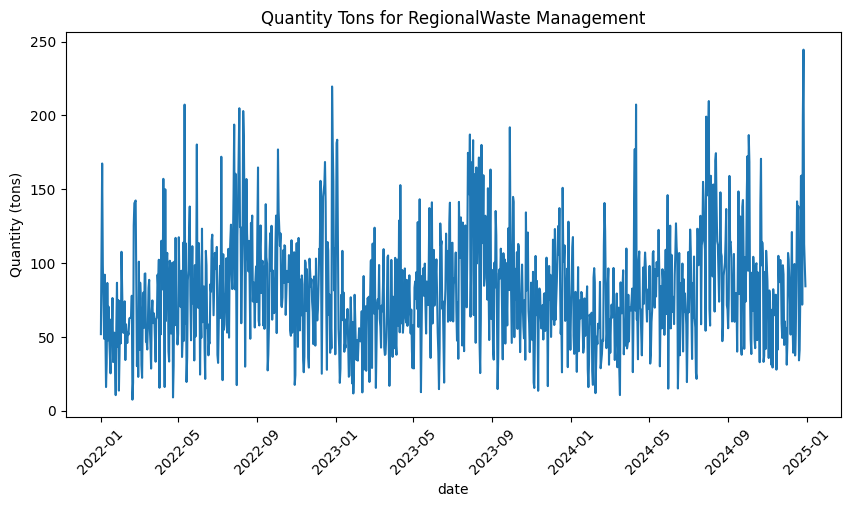

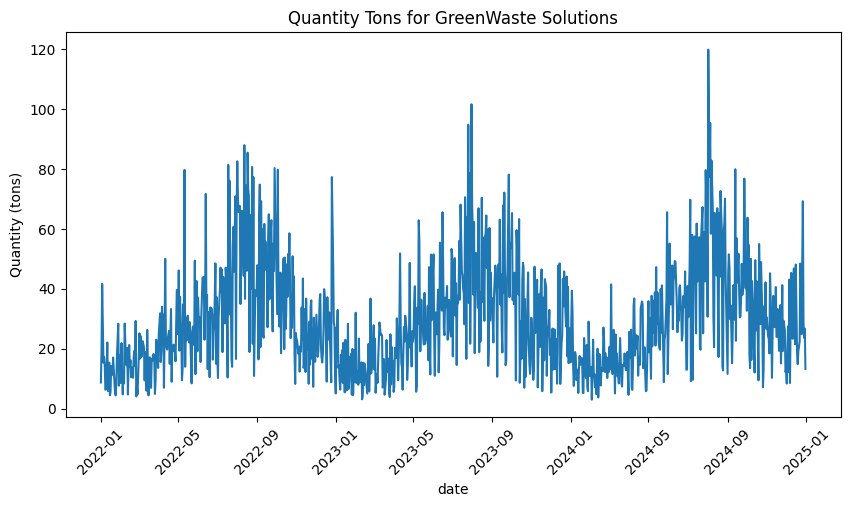

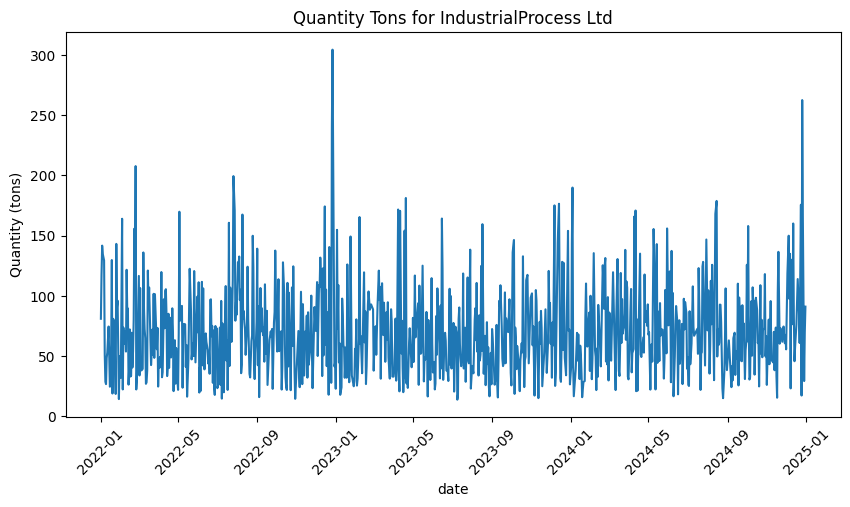

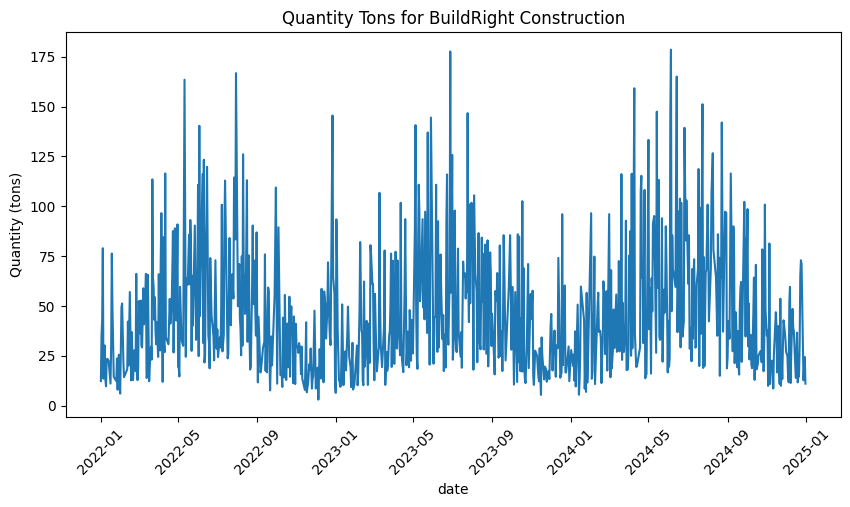

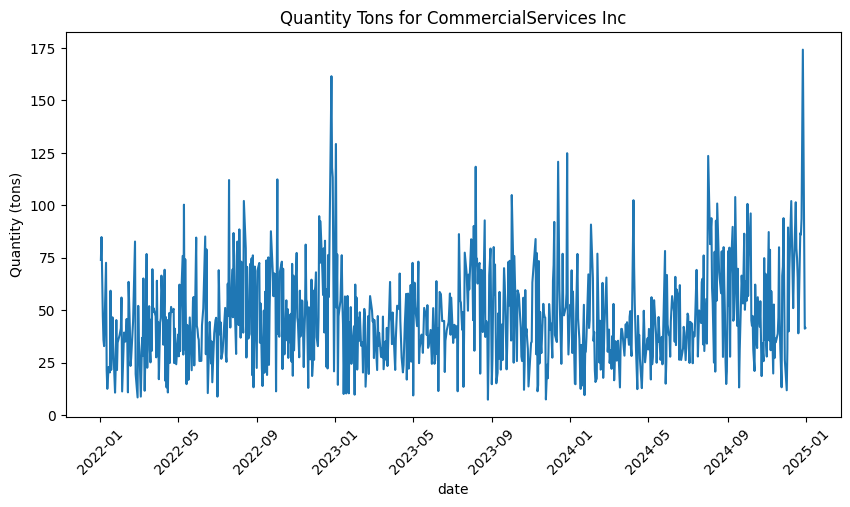

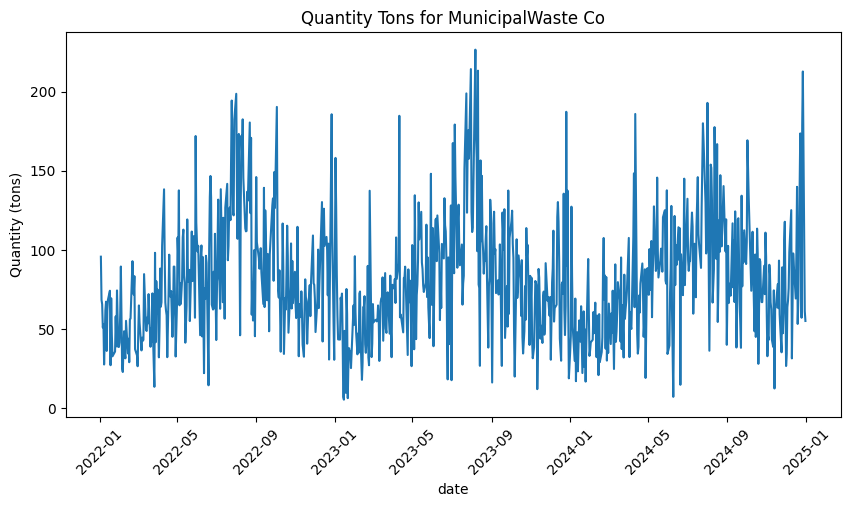

In [119]:
for company, df in company_dfs.items():
    df_filtered = df[df["quantity_tons"] > 0]  # Remove rows where quantity_tons is 0 for better visual presentation


    plt.figure(figsize=(10, 5))  
    sns.lineplot(data=df_filtered, x="date", y="quantity_tons")
    plt.title(f"Quantity Tons for {company}")
    plt.xticks(rotation=45)
    plt.ylabel("Quantity (tons)")
    plt.grid(False)
    plt.show()  


Problem when looking at individual companies: Some companies (for example CommercialServices Inc) had their first delivery later than everyone else. This means that a day is missing in their data which leads to inhomogeneous data shapes. 

In [120]:
for c in range(len(unique_companies)):
    company = list(company_dfs.keys())[c]
    print(f"Data shape for {company}:")
    print(company_dfs[company].shape)

Data shape for RegionalWaste Management:
(1095, 21)
Data shape for GreenWaste Solutions:
(1096, 21)
Data shape for IndustrialProcess Ltd:
(1096, 21)
Data shape for BuildRight Construction:
(1096, 21)
Data shape for CommercialServices Inc:
(1095, 21)
Data shape for MunicipalWaste Co:
(1094, 21)


Solution: Determine problematic dates by hand and copy the missing row from a full data frame.

In [121]:
# Add missing rows for CommercialServices Inc
if 'CommercialServices Inc' in company_dfs:
    first_row = company_dfs['GreenWaste Solutions'].iloc[[0]].copy()
    # Set quantity_tons to 0
    first_row['quantity_tons'] = 0  

    # Set all columns containing 'lag' in their name to NaN
    first_row.loc[:, first_row.columns.str.contains("lag")] = np.nan

    company_dfs['CommercialServices Inc'] = pd.concat([first_row, company_dfs['CommercialServices Inc']])
    company_dfs['CommercialServices Inc'] = company_dfs['CommercialServices Inc'].sort_index()

# Add missing rows for MunicipalWaste Co
if 'MunicipalWaste Co' in company_dfs:
    first_two_rows = company_dfs['GreenWaste Solutions'].iloc[[0, 1]].copy()
    # Set quantity_tons to 0
    first_two_rows['quantity_tons'] = 0  

    # Set all columns containing 'lag' in their name to NaN
    first_row.loc[:, first_row.columns.str.contains("lag")] = np.nan
    company_dfs['MunicipalWaste Co'] = pd.concat([first_two_rows, company_dfs['MunicipalWaste Co']])
    company_dfs['MunicipalWaste Co'] = company_dfs['MunicipalWaste Co'].sort_index()

# Add missing last row for Regional Waste Management
if 'RegionalWaste Management' in company_dfs:
    last_row = company_dfs['GreenWaste Solutions'].iloc[[-1]].copy()  # Get the last row
    # Set quantity_tons to 0
    last_row['quantity_tons'] = 0

    # Set all columns containing 'lag' in their name to NaN
    first_row.loc[:, first_row.columns.str.contains("lag")] = np.nan
    company_dfs['RegionalWaste Management'] = pd.concat([company_dfs['RegionalWaste Management'], last_row])
    company_dfs['RegionalWaste Management'] = company_dfs['RegionalWaste Management'].sort_index()

# Test if everything worked
for c in range(len(unique_companies)):
    company = list(company_dfs.keys())[c]
    print(f"Data shape for {company}:")
    print(company_dfs[company].shape)

Data shape for RegionalWaste Management:
(1096, 21)
Data shape for GreenWaste Solutions:
(1096, 21)
Data shape for IndustrialProcess Ltd:
(1096, 21)
Data shape for BuildRight Construction:
(1096, 21)
Data shape for CommercialServices Inc:
(1096, 21)
Data shape for MunicipalWaste Co:
(1096, 21)


One hyperparameter configuration is used to test the new approach

In [122]:
# Dictionary to store models and predictions
company_models = {}
company_predictions = {}

# Train-test split
split_index = int(len(feature_data) * 0.8)


# Train models and make predictions for each company
for company, df in company_dfs.items():
    
    X = df.drop(columns=['quantity_tons'])
    y = df['quantity_tons']
    
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]


    # Train an XGBoost model
    model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=250,
    learning_rate=0.07,
    max_depth=4,
    random_state=42,)

    model.fit(X_train, y_train)

    # Store the model
    company_models[company] = model

    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store predictions
    company_predictions[company] = y_pred

# Aggregate predictions
total_predicted = np.sum(list(company_predictions.values()), axis=0)

# Actual aggregated values
total_actual = feature_data["quantity_tons"][split_index:]

# Calculate RMSE for aggregated predictions
rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))
print(f'Total RMSE: {rmse:.2f}')

Total RMSE: 83.94


This approach yields better results than forecasting the aggregated quantity directly. Now Grid search is used to find well suited hyperparameter combinations.

In [123]:
company_models_grid = {}
company_predictions_grid = {}

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': np.arange(70,200,10),
    'learning_rate': np.arange(0.03,0.15,0.02),
    'max_depth': [3,4,5,6]
}

tscv = TimeSeriesSplit(n_splits=2)  


for company, df in company_dfs.items():

    X = df.drop(columns=['quantity_tons'])
    y = df['quantity_tons']

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


    tscv = TimeSeriesSplit(n_splits=2)  

    # random state for reproducability: 42
    grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', #RMSE used for scoring
    verbose=1,
    n_jobs=-1, # using all CPU cores 
    cv=tscv  # Use TimeSeriesSplit to prevent data leakage
    )

    grid_search.fit(X_train, y_train)

    # Store the best model
    best_model = grid_search.best_estimator_
    company_models_grid[company] = best_model

    # Print the best parameters for this company
    print(f"Best parameters for {company}: {grid_search.best_params_}")

    # Make predictions with the best model
    y_pred = best_model.predict(X_test)
    company_predictions_grid[company] = y_pred



Fitting 2 folds for each of 312 candidates, totalling 624 fits
Best parameters for RegionalWaste Management: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 70}
Fitting 2 folds for each of 312 candidates, totalling 624 fits
Best parameters for GreenWaste Solutions: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 90}
Fitting 2 folds for each of 312 candidates, totalling 624 fits
Best parameters for IndustrialProcess Ltd: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 120}
Fitting 2 folds for each of 312 candidates, totalling 624 fits
Best parameters for BuildRight Construction: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 90}
Fitting 2 folds for each of 312 candidates, totalling 624 fits
Best parameters for CommercialServices Inc: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 140}
Fitting 2 folds for each of 312 candidates, totalling 624 fits
Best parameters for MunicipalWaste Co: {'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 70}


In [124]:
total_predicted_grid = np.sum(list(company_predictions_grid.values()), axis=0)

rmse_grid = np.sqrt(mean_squared_error(total_actual, total_predicted_grid))
print(f'XGBoost RMSE: {rmse_grid:.2f}')

XGBoost RMSE: 88.38


Why is RMSE after Gridsearch worse??????

What follows is a comparions of the results so far with 2 naive approaches. The first approach uses the last observed value as a forecast for the next 3 days (3 because our smallest lagged feature with XGBoost is 3 which means we can do 3 day ahead forecasts at most). The second naive approach uses the historic mean to forecast on the test set.

In [125]:
naive_last_obs = np.empty_like(total_actual)
naive_last_obs[:] = np.nan  

for i in range(0, len(total_actual), 3):  # Start from index 3 and update every 3 steps
    naive_last_obs[i:i+3] = total_actual.iloc[i-1]  # Use the last observed value

# Ensure we don't go out of bounds
naive_last_obs = naive_last_obs[:len(total_actual)]
valid_indices = ~np.isnan(naive_last_obs)
naive_last_obs_rmse = np.sqrt(mean_squared_error(total_actual[valid_indices], naive_last_obs[valid_indices]))


historic_mean = np.mean(total_actual[:split_index])  # Mean of training data

naive_mean = np.full_like(total_actual, fill_value=historic_mean)

# Calculate RMSE for the mean forecast
naive_mean_rmse = np.sqrt(mean_squared_error(total_actual, naive_mean))


print(f'XGBoost RMSE:                         {rmse_grid:.2f}')
print(f'Naïve Forecast last observation RMSE: {naive_last_obs_rmse:.2f}')
print(f'Mean-Based Naïve Forecast RMSE:       {naive_mean_rmse:.2f}')


XGBoost RMSE:                         88.38
Naïve Forecast last observation RMSE: 209.28
Mean-Based Naïve Forecast RMSE:       147.90


Visualizing results. Adjust start and end to view specific ranges.

XGBoost RMSE for 0-31 predictions:                         86.26
Naïve Forecast last observation RMSE for 0-31 predictions: 171.28
Mean-Based Naïve Forecast for 0-31 predictions:            126.22


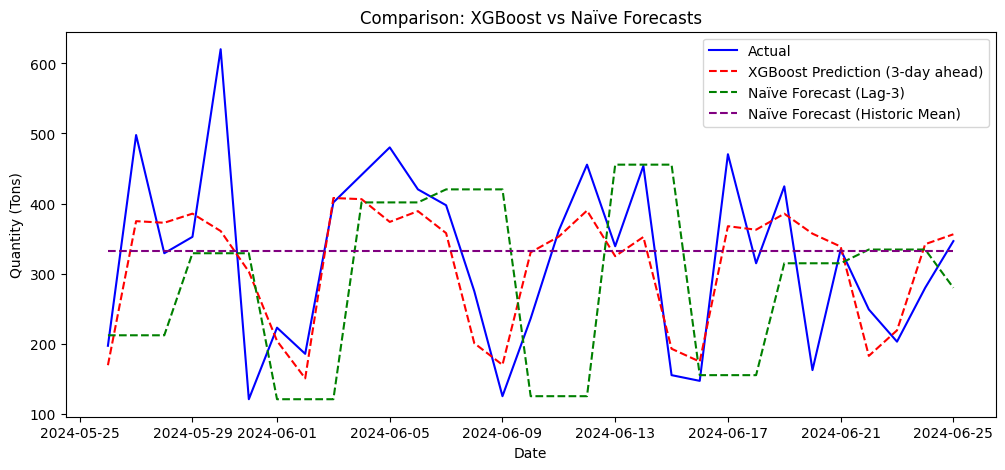

In [126]:
# Results for first 31 Days of the test set
start = 0 
end   = 31


# Calculating RMSE for specific ranges
sum_squared_errors = 0

for i in range(start,end):
    squared_error = (total_actual.iloc[i] - total_predicted_grid[i])**2
    sum_squared_errors += squared_error
rmse_range1 = np.sqrt(sum_squared_errors / (end-start))


sum_squared_errors_naive = 0

for i in range(start, end):
    squared_error_naive = (total_actual.iloc[i] - naive_last_obs[i]) ** 2
    sum_squared_errors_naive += squared_error_naive
rmse_range2 = np.sqrt(sum_squared_errors_naive / (end-start))


sum_squared_errors_mean = 0

for i in range(start, end):
    squared_error_mean = (total_actual.iloc[i] - naive_mean[i]) ** 2
    sum_squared_errors_mean += squared_error_mean
rmse_range3 = np.sqrt(sum_squared_errors_mean / (end-start))

print(f'XGBoost RMSE for {start}-{end} predictions:                         {rmse_range1:.2f}')
print(f'Naïve Forecast last observation RMSE for {start}-{end} predictions: {rmse_range2:.2f}')
print(f'Mean-Based Naïve Forecast for {start}-{end} predictions:            {rmse_range3:.2f}')

plt.figure(figsize=(12, 5))

plt.plot(X_test.index[start:end], total_actual[start:end], label="Actual", color='blue')
plt.plot(X_test.index[start:end], total_predicted_grid[start:end], label="XGBoost Prediction (3-day ahead)", color='red', linestyle="dashed")
plt.plot(X_test.index[start:end], naive_last_obs[start:end], label="Naïve Forecast (Lag-3)", color='green',linestyle="dashed")
plt.plot(X_test.index[start:end], naive_mean[start:end], label="Naïve Forecast (Historic Mean)", color='purple', linestyle="dashed")
plt.xlabel('Date')
plt.ylabel('Quantity (Tons)')
plt.title('Comparison: XGBoost vs Naïve Forecasts')
plt.legend()
plt.show()